In [256]:
from __future__ import print_function
from collections import Counter
from collections import OrderedDict
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import calendar
import datetime
import re
from math import log
from scipy import stats
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#load the pickle object for quick access
result = pd.read_pickle("/Users/Matt/Documents/Stevens/BIA660 Web Analytics/yelp_dataset_challenge_academic_dataset/Data/500_Dataset")

In [126]:
result.head()

,business_id,date,review_id,stars_x,text,type_x,user_id,votes,attributes,categories,...,hours,latitude,longitude,name,neighborhoods,open,review_count,stars_y,state,type_y
0,mpDxBBGywUE6GRRKja3sBA,2005-09-06,HtqQG2umwuVGbMbHapBm-A,4,"Upscale soul food. Cornbread, fried chicken, ...",review,Puv7uq6Wx4AtL_jVpC4d3w,"{u'funny': 0, u'useful': 0, u'cool': 0}","{u'Wheelchair Accessible': True, u'Take-out': ...","[Soul Food, Southern, Restaurants]",...,"{u'Monday': {u'close': u'21:30', u'open': u'11...",35.227318,-80.84013,Mert's Heart & Soul,[First Ward],True,652,3.5,NC,business
1,mpDxBBGywUE6GRRKja3sBA,2006-03-02,WIe91sMuGkxvPTEBXyIyrQ,4,Cornbread and Sweet Tea. If that was all you a...,review,3Gazlt5RwZQIu1ZWMwi0cg,"{u'funny': 0, u'useful': 0, u'cool': 0}","{u'Wheelchair Accessible': True, u'Take-out': ...","[Soul Food, Southern, Restaurants]",...,"{u'Monday': {u'close': u'21:30', u'open': u'11...",35.227318,-80.84013,Mert's Heart & Soul,[First Ward],True,652,3.5,NC,business
2,mpDxBBGywUE6GRRKja3sBA,2006-11-07,BPZqNCPQz-EC2AOi9WLrEQ,3,This place is ok. It can be crowded (meaning ...,review,K5dxGhJ99TmS6La6krwkcg,"{u'funny': 0, u'useful': 0, u'cool': 0}","{u'Wheelchair Accessible': True, u'Take-out': ...","[Soul Food, Southern, Restaurants]",...,"{u'Monday': {u'close': u'21:30', u'open': u'11...",35.227318,-80.84013,Mert's Heart & Soul,[First Ward],True,652,3.5,NC,business
3,mpDxBBGywUE6GRRKja3sBA,2007-05-24,QNa7UGC5R_yLY7oJpWQs-Q,4,I think that this place is worth going to just...,review,AJtc4UMsCDw8QJQMyfHa_w,"{u'funny': 0, u'useful': 0, u'cool': 0}","{u'Wheelchair Accessible': True, u'Take-out': ...","[Soul Food, Southern, Restaurants]",...,"{u'Monday': {u'close': u'21:30', u'open': u'11...",35.227318,-80.84013,Mert's Heart & Soul,[First Ward],True,652,3.5,NC,business
4,mpDxBBGywUE6GRRKja3sBA,2007-09-25,S9g5NqdkuU28C6XW0aBd0g,4,"Ah Mert's! I love this place! It's not fancy, ...",review,bxGekdRVUysLtZ4BYF8wEQ,"{u'funny': 0, u'useful': 1, u'cool': 1}","{u'Wheelchair Accessible': True, u'Take-out': ...","[Soul Food, Southern, Restaurants]",...,"{u'Monday': {u'close': u'21:30', u'open': u'11...",35.227318,-80.84013,Mert's Heart & Soul,[First Ward],True,652,3.5,NC,business


In [255]:
def exploreBusiness(businessID):
    #exploratory Analysis for business ID mpDxBBGywUE6GRRKja3sBA
    business1 = result[result["business_id"]==businessID]
    #change date into datetime
    business1['date'] = pd.to_datetime(business1['date'])
    business1['Year-Month'] = business1.date.map(lambda x: x.strftime('%Y-%m'))
    business1['Qdate'] = [date - pd.tseries.offsets.DateOffset(days=1) + pd.tseries.offsets.QuarterEnd() for date in business1.date]
    #review_counts = business1.groupby('Year-Month')['review_id'].count()
    review_counts = business1.groupby('Year-Month')['stars_x'].count()
    ax = review_counts.plot(kind='bar', figsize=(20,10))
    return review_counts, business1

/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

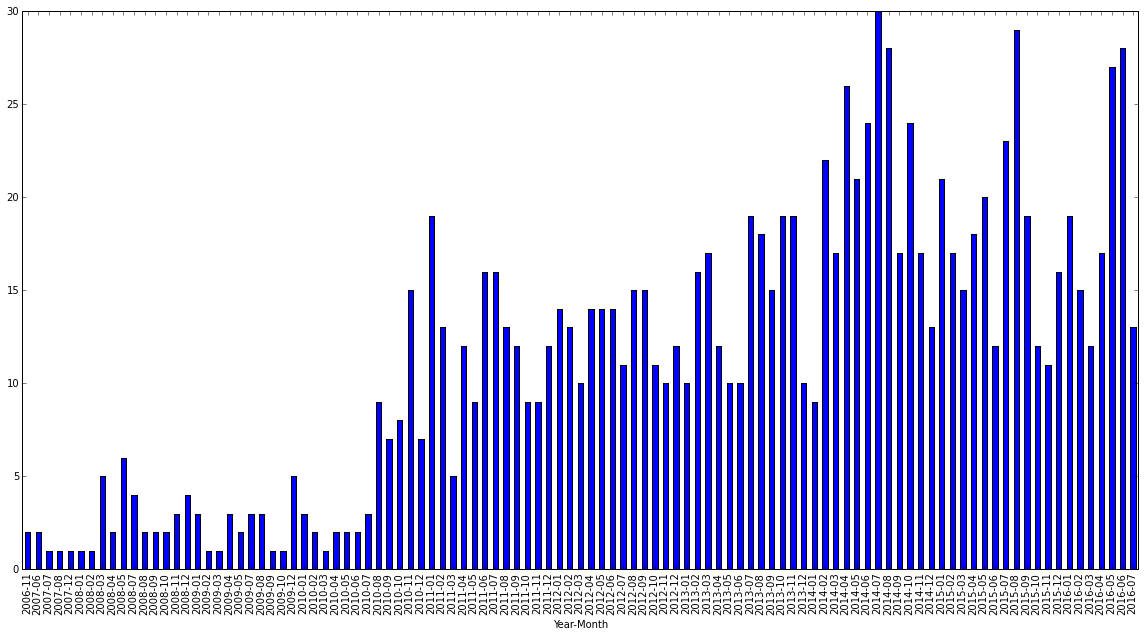

In [136]:
review_counts, business_df = exploreBusiness('3Q0QQPnHcJuX1DLCL9G9Cg')

In [112]:
def slidingTtest(review_counts):
    anomaly = {} #initialize dict
    d = {}
    for ind, value in review_counts.iteritems():
        d[ind] = value
        anomaly[ind]=-1
        #print(ind)
        if len(d) >= 31: #need 30 samples because the data is non-normal
            #t-test to compare the next month/year sample to the mean of all the prior ones   
            one_sample = stats.ttest_1samp(d.values()[0:(len(d)-2)], d.values()[len(d)-1]) #compares the entire period
            if one_sample.pvalue < 0.05: #null hypothesis: new sample = prior mean
                anomaly[ind]=1  #there is a statistically signifant difference, where the new sample != prior mean
            #else:
            #    anomaly[ind]=-1 #no evidence of a difference
                
        
    
    return anomaly

In [121]:
#locate the period where there is a change in the anomaly[ind] values
def choosePeriods(anomaly):
    period={}
    placeholder=-1
    
    keylist = anomaly.keys()
    keylist.sort()
    for key in keylist:
        if anomaly[key] != placeholder:
            period[key]=1
            placeholder = placeholder * (-1)
        else:
            period[key]=0
    return period            

In [263]:
#if there is a change in the anomaly, get the common words
def getCommonWords(business_df, business_id, period):
    common={}
    final=''
    keylist = period.keys()
    keylist.sort()
    for key in keylist:
        if period[key] == 1:
            text=business_df[(business_df['Year-Month']==key)].text
            text=text.to_string()
            text = re.sub('\W+', ' ',text)
            default_stopwords = set(nltk.corpus.stopwords.words('english'))
            custom_stopwords = set((u'–', '...'))
            all_stopwords = default_stopwords | custom_stopwords
            words = nltk.word_tokenize(text)
            
            words = [word for word in words if len(word) > 2] #remove words that are only 1 character
            # Remove numbers
            words = [word for word in words if not word.isnumeric()]

            # Lowercase all words (default_stopwords are lowercase too)
            words = [word.lower() for word in words]

            #remove words that are stopwords
            words = [word for word in words if word not in all_stopwords]

            # Calculate frequency distribution
            fdist = nltk.FreqDist(words)
            
            for word, frequency in fdist.most_common(5):
                final+=str(word+' ')
    common[business_id] = final
    
    return common

In [264]:
#anomaly=slidingTtest(review_counts)
#period= choosePeriods(anomaly)
#getCommonWords(business_df,'3Q0QQPnHcJuX1DLCL9G9Cg',period)

{'3Q0QQPnHcJuX1DLCL9G9Cg': 'pho service vietnamese fast love '}

In [ ]:
for business in result.business_id.unique():
    common={}
    business_id = business
    review_counts, business_df = exploreBusiness(business)
    anomaly=slidingTtest(review_counts)
    period= choosePeriods(anomaly)
    print(getCommonWords(business_df,business_id,period))
    

/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Matt/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{u'mpDxBBGywUE6GRRKja3sBA': 'pork good taste chops mert '}
{u'3Q0QQPnHcJuX1DLCL9G9Cg': 'airport okay time say loiter airport time rocking comment gates airport charlotte airports one douglas '}
{u'tb24fvNJfHhyKEXkKn12Xw': 'diner welcome incarnation friday one '}
{u'qMkIbQFrROSnPaQ7at85-w': 'weddings bit cow holy visiting beautiful place enjoy adults nerd flashlight tine visit tour first '}
{u'AkOruz5CrCxUmXe1p_WoRg': 'lunch far well japanese fast '}
{u'R8VwdLyvsp9iybNqRvm94g': 'place saying love people fabulous '}
{u'SDwYQ6eSu1htn8vHWv128g': 'postino finally went atmosphere nlove great place much food excellent '}
{u'hW0Ne_HTHEAgGF1rAdmR-g': 'sky take fly harbor airport airport like home yes leave airport easy phoenix phx like '}
{u'rDvz5jX65gpfONFu7er9Tw': 'tacos street yum great burrito great good tacos mexican get mexican place good tacos simple '}
{u'wZwZcte4lcbu51NOzCjWbQ': 'opinion neatest restaurants one '}
{u'L9UYbtAUOcfTgZFimehlXw': 'one places always place love '}
{u'Pgp3gbOQ

In [185]:
#results[(results.business_id=='3Q0QQPnHcJuX1DLCL9G9Cg') && (results.date==period[key])]
#text=business_df[(business_df.business_id=='3Q0QQPnHcJuX1DLCL9G9Cg') & (business_df['Year-Month']=='2010-09')].text
